# Question Classification using BERT-base
- Finetuning bert on the dataset for few epochs.
- The best accuracy on the test set is **0.97**

In [21]:
import pandas as pd
import random
import os
import time
import numpy as np
import torch


def set_seed(seed):
    """Set seed"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(2020) # for reproducibility of random modules if used

# Data Loading

In [2]:
f_train = open('data/train_5500.txt', 'r+')
f_test = open('data/TREC_10.txt', 'r+')

train = pd.DataFrame(f_train.readlines(), columns = ['Question'])
test = pd.DataFrame(f_test.readlines(), columns = ['Question'])

train['QType'] = train.Question.apply(lambda x: x.split(' ', 1)[0])
train['Question'] = train.Question.apply(lambda x: x.split(' ', 1)[1])
train['QType-Coarse'] = train.QType.apply(lambda x: x.split(':')[0])
train['QType-Fine'] = train.QType.apply(lambda x: x.split(':')[1])
test['QType'] = test.Question.apply(lambda x: x.split(' ', 1)[0])
test['Question'] = test.Question.apply(lambda x: x.split(' ', 1)[1])
test['QType-Coarse'] = test.QType.apply(lambda x: x.split(':')[0])
test['QType-Fine'] = test.QType.apply(lambda x: x.split(':')[1])

In [3]:
train.head()

,Question,QType,QType-Coarse,QType-Fine
0,How did serfdom develop in and then leave Russ...,DESC:manner,DESC,manner
1,What films featured the character Popeye Doyle...,ENTY:cremat,ENTY,cremat
2,How can I find a list of celebrities ' real na...,DESC:manner,DESC,manner
3,What fowl grabs the spotlight after the Chines...,ENTY:animal,ENTY,animal
4,What is the full form of .com ?\n,ABBR:exp,ABBR,exp


In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(pd.Series(train['QType-Coarse'].tolist() + test['QType-Coarse'].tolist()).values)
train['QType-Coarse'] = le.transform(train['QType-Coarse'].values)
test['QType-Coarse'] = le.transform(test['QType-Coarse'].values)
train.head()

,Question,QType,QType-Coarse,QType-Fine
0,How did serfdom develop in and then leave Russ...,DESC:manner,1,manner
1,What films featured the character Popeye Doyle...,ENTY:cremat,2,cremat
2,How can I find a list of celebrities ' real na...,DESC:manner,1,manner
3,What fowl grabs the spotlight after the Chines...,ENTY:animal,2,animal
4,What is the full form of .com ?\n,ABBR:exp,0,exp


In [5]:
train['QType-Coarse'].unique()

array([1, 2, 0, 3, 5, 4])

## EDA
- The train and test class distributions are similar with class '0' having less number of examples.

<AxesSubplot:xlabel='QType-Coarse', ylabel='count'>

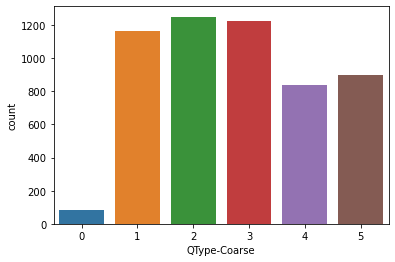

In [6]:
import seaborn as sns
sns.countplot(train['QType-Coarse'])

<AxesSubplot:xlabel='QType-Coarse', ylabel='count'>

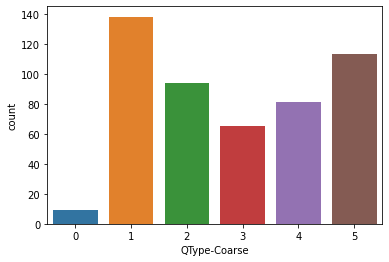

In [7]:
sns.countplot(test['QType-Coarse'])

<AxesSubplot:ylabel='Frequency'>

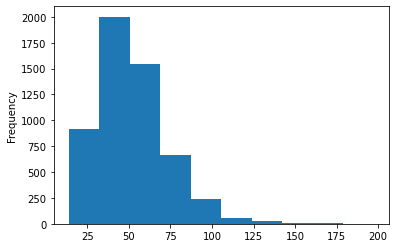

In [8]:
train['Question'].str.len().plot.hist(figsize = (6, 4))

# Using BERT

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer,BertModel,AdamW,get_linear_schedule_with_warmup


MAX_LEN = 128

class QuestionDataset(Dataset):

  def __init__(self, questions, labels, tokenizer, max_len):
    self.questions = questions
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.questions)
  
  def __getitem__(self, item):
    question = str(self.questions[item])
    label = self.labels[item]

    encoding = self.tokenizer.encode_plus(
      question,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
        truncation=True,
      return_tensors='pt',
    )

    return {
      'question': question,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'labels': torch.tensor(label, dtype=torch.long)
    }

In [10]:
BATCH_SIZE = 32
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
train_data_loader = DataLoader(QuestionDataset(train['Question'].to_numpy(),train['QType-Coarse'].to_numpy() ,tokenizer, MAX_LEN), batch_size=BATCH_SIZE)
test_data_loader = DataLoader(QuestionDataset(test['Question'].to_numpy(),test['QType-Coarse'].to_numpy() ,tokenizer, MAX_LEN), batch_size=BATCH_SIZE)

In [11]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['question', 'input_ids', 'attention_mask', 'labels'])

In [12]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])


In [13]:
class QuestionClassifier(nn.Module):

  def __init__(self, n_classes):
    super(QuestionClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.1)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [14]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["labels"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [15]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [16]:
from collections import defaultdict 
def train_model(lr,epochs,num_warmup_steps,num_train_steps):
    model = QuestionClassifier(len(train['QType-Coarse'].unique()))
    model = model.to(device)

    optimizer = AdamW(model.parameters(), lr=lr, correct_bias=False)


    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=num_warmup_steps,
      num_training_steps=num_train_steps
    )

    loss_fn = nn.CrossEntropyLoss().to(device)
    history = defaultdict(list)
    best_accuracy = 0.

    for epoch in range(int(epochs)):

        print(f'Epoch {epoch + 1}/{int(epochs)}')
        print('-' * 10)

        train_acc, train_loss = train_epoch(
        model,
        train_data_loader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        len(train_data_loader.dataset)
        )

        print(f'Train loss {train_loss} accuracy {train_acc}')

        test_acc, test_loss = eval_model(
        model,
        test_data_loader,
        loss_fn, 
        device, 
        len(test_data_loader.dataset)
        )

        print(f'test   loss {test_loss} accuracy {test_acc}')
        print()

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['test_acc'].append(test_acc)
        history['test_loss'].append(test_loss)
        if test_acc > best_accuracy:
            best_accuracy = test_acc

    return model,history,best_accuracy

In [19]:
import torch.nn.functional as F
def get_predictions(model, data_loader):
  model = model.eval()
  
  questions = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      texts = d["question"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      questions.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return questions, predictions, prediction_probs, real_values

In [25]:
from sklearn.metrics import f1_score, classification_report
BATCH_SIZE = 32
LEARNING_RATE = [2e-5,3e-5,5e-5] # recommended by the bert paper
NUM_TRAIN_EPOCHS = [2.0,3.0,4.0]  # recommended by the bert paper
# Warmup is a period of time where the learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_train_steps = int(len(train_data_loader.dataset) / BATCH_SIZE * 3.0)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)
model, history, accuracy = train_model(3e-5,3.0,num_warmup_steps,num_train_steps)

_, pred, _, true = get_predictions(model,test_data_loader)

# print(classification_report(true, pred))


Epoch 1/3
----------
Train loss 0.5533362667332267 accuracy 0.8088774761555393
test   loss 0.15251974656712264 accuracy 0.9580000000000001

Epoch 2/3
----------
Train loss 0.10937990216342242 accuracy 0.9701027146001467
test   loss 0.12258341038250364 accuracy 0.97

Epoch 3/3
----------
Train loss 0.038931484680012826 accuracy 0.9908290535583273
test   loss 0.12722792476415634 accuracy 0.972



In [24]:
print(classification_report(true, pred))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94         9
           1       0.95      1.00      0.98       138
           2       0.99      0.89      0.94        94
           3       0.98      0.98      0.98        65
           4       0.96      0.99      0.98        81
           5       0.98      0.99      0.99       113

    accuracy                           0.97       500
   macro avg       0.98      0.96      0.97       500
weighted avg       0.97      0.97      0.97       500



training...lr_2e-05_epoch_2.0
Epoch 1/2
----------
Train loss 0.6181323294533275 accuracy 0.7798972853998533
test   loss 0.18317736696917564 accuracy 0.9500000000000001

Epoch 2/2
----------
Train loss 0.1113686280717191 accuracy 0.969369038884813
test   loss 0.10946443979628384 accuracy 0.972

training...lr_2e-05_epoch_3.0
Epoch 1/3
----------
Train loss 0.614806680716792 accuracy 0.7820983125458548
test   loss 0.2283167386194691 accuracy 0.9380000000000001

Epoch 2/3
----------
Train loss 0.12259348054901201 accuracy 0.9658840792369773
test   loss 0.16585081059020013 accuracy 0.966

Epoch 3/3
----------
Train loss 0.043425518128890214 accuracy 0.9878943506969919
test   loss 0.14455903857015073 accuracy 0.97

training...lr_2e-05_epoch_4.0
Epoch 1/4
----------
Train loss 0.6499913869240479 accuracy 0.7670579603815114
test   loss 0.17426120792515576 accuracy 0.9580000000000001

Epoch 2/4
----------
Train loss 0.11963644008321023 accuracy 0.9655172413793104
test   loss 0.1593807832978200

(0.0, 1.0)

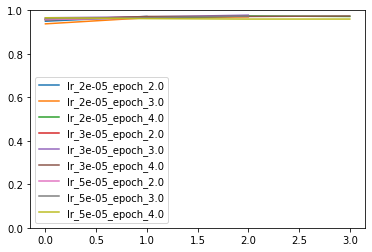

In [23]:
import matplotlib.pyplot as plt
model_names=[]
histories = []
accuracies=[]
for i in range(3):
    for j in range(3):
        model_names.append(f"lr_{LEARNING_RATE[i]}_epoch_{NUM_TRAIN_EPOCHS[j]}")
        print(f"training...{model_names[-1]}")
        num_train_steps = int(len(train_data_loader.dataset) / BATCH_SIZE * NUM_TRAIN_EPOCHS[j])
        num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)
        _, history, accuracy = train_model(LEARNING_RATE[i],NUM_TRAIN_EPOCHS[j],num_warmup_steps,num_train_steps)
        histories.append(history)
        accuracies.append(accuracy)
accuracies = [a.item() for a in accuracies]

print(model_names)
print(accuracies)

for history,model_name in zip(histories,model_names):
    plt.plot(history["test_acc"],label=model_name)
    
plt.legend()
plt.ylim([0, 1])